In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import PIL
import PIL.Image
import tensorflow as tf

from pathlib import Path
from tensorflow.io import read_file
from tensorflow.image import decode_image
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.constraints import max_norm
from sklearn.model_selection import KFold
from keras.optimizers import Adam
from tensorflow.keras import activations, layers, optimizers, losses, Sequential
from sklearn.model_selection import StratifiedKFold , KFold ,RepeatedKFold


# Dataset

In [2]:
# load the dataset

data_directory = pathlib.Path("/Users/margheritamenegazzi/Desktop/ML/Project/data") 

In [ ]:
# delete corrupted dog images

for image in sorted((data_directory/'Dogs').glob('*')):
    try:
        img = read_file(str(image))
        img = decode_image(img)
        
        if img.ndim != 3:
            print(f"[FILE_CORRUPT] {str(image).split('/')[-1]} DELETED")
            image.unlink()
            
    except Exception as e:
        print(f"[ERR] {str(image).split('/')[-1]}: {e} DELETED")
        image.unlink()

In [ ]:
# delete corrupted cat images

for image in sorted((data_directory/'Cats').glob('*')):
    try:
        img = read_file(str(image))
        img = decode_image(img)
        
        if img.ndim != 3:
            print(f"[FILE_CORRUPT] {str(image).split('/')[-1]} DELETED")
            image.unlink()
            
    except Exception as e:
        print(f"[ERR] {str(image).split('/')[-1]}: {e} DELETED")
        image.unlink()

In [3]:
pic_count = len(list(data_directory.glob("*/*.jpg")))
print(pic_count)

24920


After deleting corrputed images from the dataset, 24920 pictures remain.
Now the training set, validation set and test set are created. 60% of the original dataset is used for training and 40% is used for validation.

In [4]:
batch_size = 42
img_height = 100
img_width = 100
color_mode='rgb'

In [5]:
# training set

train_data = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    color_mode=color_mode,
    validation_split=0.4,
    subset="training",
    seed=42,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)


Found 24920 files belonging to 2 classes.
Using 14952 files for training.


In [6]:
# validation set

val_data = tf.keras.utils.image_dataset_from_directory(
    data_directory,
    color_mode=color_mode,
    validation_split=0.4,
    subset="validation",
    seed=42,
    shuffle=True,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 24920 files belonging to 2 classes.
Using 9968 files for validation.


The test set is created taking data from the validation set. The test set is balanced: it has around the same amount of cat images and dog images.

In [7]:
# test set

val_len = len(val_data)
pcent = 0.16
tot_batches = int(val_len*pcent)
test_data = val_data.skip(tot_batches)
val_data = val_data.take(tot_batches)

In [8]:
# unbatch test data

test_data_1 = test_data.unbatch()
images_test = list(test_data_1.map(lambda x, y: x))
labels_test = list(test_data_1.map(lambda x, y: y))

print(len(labels_test))
print(len(images_test))


8372
8372


In [9]:
labels_test.count(1)

4207

In [10]:
labels_test.count(0)

4165

# Data Visualization

In this section some of the images from the dataset are shown to have an idea of what is being classified.

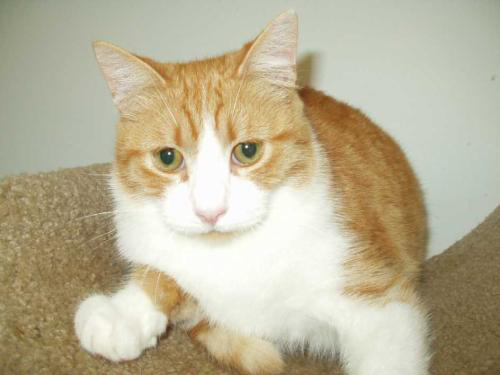

In [11]:
cats = list(data_directory.glob("Cats/*"))
PIL.Image.open(str(cats[1200]))

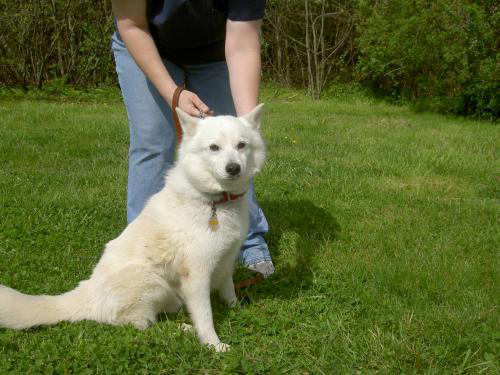

In [12]:
dogs = list(data_directory.glob("Dogs/*"))
PIL.Image.open(str(dogs[888]))

In [13]:
label_names = train_data.class_names
print(label_names)

['Cats', 'Dogs']


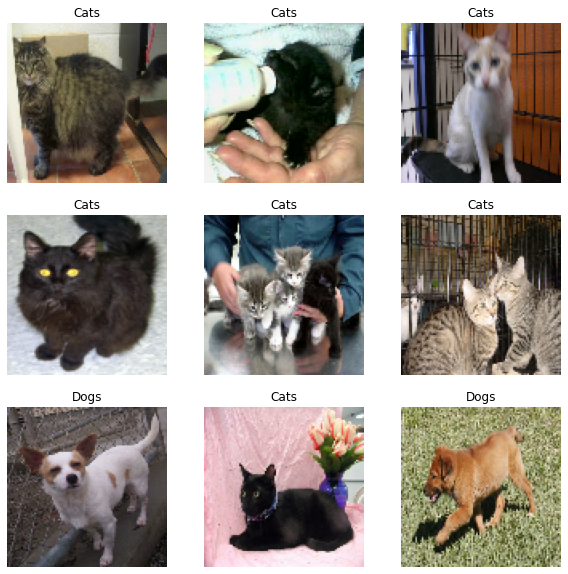

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap="gray")
        plt.title(label_names[labels[i]])
        plt.axis("off")

In [15]:
for image_batch, labels_batch in train_data:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(42, 100, 100, 3)
(42,)


## Model 1: FeedForward NN

The first model is a Feed Forward Neural Network with an input layer, two hidden layers and an output layer.
The first layer is a pre-processing layer that scales the input pixel values between 0 and 1 by dividing them by 255. The shape of the input data is specified as a 100x100 image with 3 color channels (RGB).
The second layer is used to flatten the image in input into a 1D vector. This is necessary to connect it to the subsequent fully connected layers.
The following two layers are fully connected layers with respectively 128 and 32 neurons, and they use the ReLU activation function to learn complex patterns in the data and introduce non-linearity to the network.
The final layer outputs the predicted probabilities of an image being classified correctly.


In [16]:
# model definition

model_1 = Sequential([
  layers.Rescaling(1./255, input_shape=(100, 100, 3)),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(32, activation='relu'),  
  layers.Dense(2),
       
])

In [17]:
# compile the model

model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 flatten (Flatten)           (None, 30000)             0         
                                                                 
 dense (Dense)               (None, 128)               3840128   
                                                                 
 dense_1 (Dense)             (None, 32)                4128      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 3,844,322
Trainable params: 3,844,322
Non-trainable params: 0
_________________________________________________________________


This model is then trained using the Training set and Validation set that were created at the beginning, 10 training epochs are used. The loss function specified is the Sparse Categorical Crossentropy.

In [19]:
# train the model

epochs=10
history = model_1.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs
)

Epoch 1/10
356/356 [==============================] - 44s 120ms/step - loss: 1.3941 - accuracy: 0.5436 - val_loss: 1.1868 - val_accuracy: 0.5138
Epoch 2/10
356/356 [==============================] - 49s 137ms/step - loss: 0.7601 - accuracy: 0.5647 - val_loss: 0.8019 - val_accuracy: 0.5382
Epoch 3/10
356/356 [==============================] - 49s 136ms/step - loss: 0.6905 - accuracy: 0.5896 - val_loss: 0.7266 - val_accuracy: 0.5639
Epoch 4/10
356/356 [==============================] - 48s 132ms/step - loss: 0.6633 - accuracy: 0.6104 - val_loss: 0.6365 - val_accuracy: 0.6253
Epoch 5/10
356/356 [==============================] - 48s 132ms/step - loss: 0.6476 - accuracy: 0.6312 - val_loss: 0.6400 - val_accuracy: 0.6335
Epoch 6/10
356/356 [==============================] - 46s 128ms/step - loss: 0.6433 - accuracy: 0.6279 - val_loss: 0.6381 - val_accuracy: 0.6216
Epoch 7/10
356/356 [==============================] - 46s 128ms/step - loss: 0.6353 - accuracy: 0.6338 - val_loss: 0.6509 - val_ac

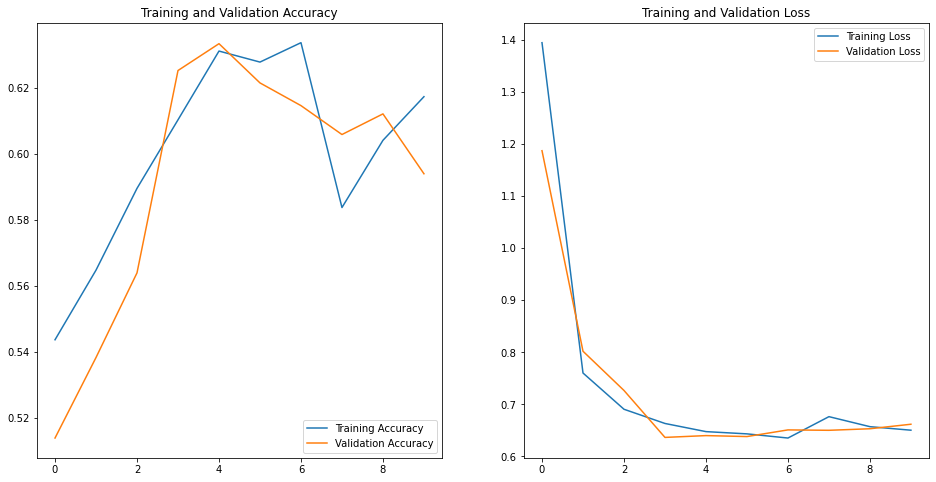

In [20]:
# plot accuracies and losses

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The model reaches the best validation accuracy at epoch 5 at 63%, after that point some overfitting behavior can be observed.

## Model 2: Convolutional NN

This model has the same type of pre-processing input layer as the previous model.
It then has three convolutional layers where filters have a 3x3 dimension, and the number of filters gradually increases in each layer to capture more complex patterns.
Each convolutional layer is followed by a max-pooling layer that reduces the spatial dimensions of the filter map by taking the maximum value within each pooling window.
A flatten layer is used to flatten the 3D output from the last convolutional layers into a 1D vector. This prepares the data for input into the fully connected layer.
A fully connected layer with 128 neurons layer takes the flattened input vector and performs a linear transformation. All the convolutional layers and the fully connected layer implement the ReLU activation function. 
Finally, the output layer with 2 neurons represents the predicted classes. 

In [21]:
# build the model

num_classes = len(label_names)

model_2 = Sequential([
  layers.Rescaling(1./255, input_shape=(100, 100, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2)
])

In [22]:
# compile the model

model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)       

Again, the model is trained using the Training set and Validation set in 10 epochs, and the Sparse Categorical Crossentropy loss function is used.

In [24]:
# train the model

epochs=10
history = model_2.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs
)

Epoch 1/10
356/356 [==============================] - 132s 365ms/step - loss: 0.6177 - accuracy: 0.6576 - val_loss: 0.5403 - val_accuracy: 0.7281
Epoch 2/10
356/356 [==============================] - 130s 364ms/step - loss: 0.5005 - accuracy: 0.7570 - val_loss: 0.4532 - val_accuracy: 0.7995
Epoch 3/10
356/356 [==============================] - 137s 384ms/step - loss: 0.4272 - accuracy: 0.8024 - val_loss: 0.4494 - val_accuracy: 0.7964
Epoch 4/10
356/356 [==============================] - 148s 415ms/step - loss: 0.3762 - accuracy: 0.8306 - val_loss: 0.4502 - val_accuracy: 0.8026
Epoch 5/10
356/356 [==============================] - 148s 414ms/step - loss: 0.3308 - accuracy: 0.8543 - val_loss: 0.4319 - val_accuracy: 0.8214
Epoch 6/10
356/356 [==============================] - 131s 367ms/step - loss: 0.2843 - accuracy: 0.8755 - val_loss: 0.4468 - val_accuracy: 0.8315
Epoch 7/10
356/356 [==============================] - 130s 364ms/step - loss: 0.2254 - accuracy: 0.9057 - val_loss: 0.4795 -

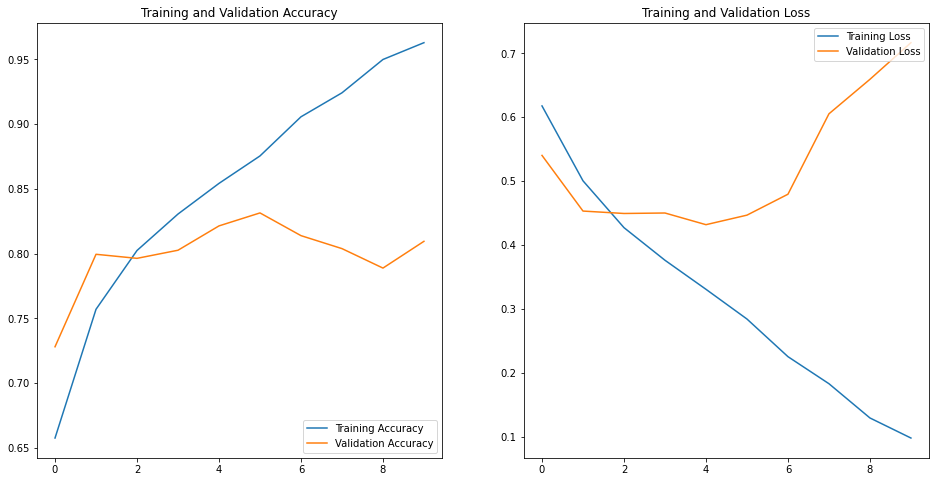

In [25]:
# plot accuracies and losses

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This model reaches a peak validation accuracy of 83% at epoch 6, after that point some overfitting behavior is still present.
This overfitting could be caused by a lack of regularization techniques applied in the model. 

## Model 3: Convolutional NN with Dropout Layers

The third and final model of this project  is just a slight modification of the previous one, some changes were made. Now at each convolutional layer not only the number of filters, but also the size of the filters increases. This allows the convolutional layers to extract increasingly complex features from the input images.
After each max pooling layer, a Dropout layer is added with a dropout rate of 20%, so 20% of neurons are randomly deactivated during training. Also, the fully connected layer now uses the sigmoidal activation function, because it  squashes the input values into the range of 0 to 1 and this makes it convenient for our binary classification task.


In [26]:
# build the model

model_3 = Sequential([
  layers.Rescaling(1./255, input_shape=(100, 100, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(rate= 0.2),  
  layers.Conv2D(32, 6, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(rate= 0.2),  
  layers.Conv2D(64, 9, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(rate= 0.2),  
  layers.Flatten(),
  layers.Dense(128, activation='sigmoid'),
  layers.Dense(2),
])

In [27]:
# compile the model

model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 50, 50, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 32)        18464     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                  

Once again, the model is trained using the Training set and Validation set in 10 epochs, and the Sparse Categorical Crossentropy loss function is used.

In [29]:
# train the model

epochs=10
history = model_3.fit(
  train_data,
  validation_data=val_data,
  epochs=epochs
)

Epoch 1/10
356/356 [==============================] - 302s 845ms/step - loss: 0.6871 - accuracy: 0.5383 - val_loss: 0.6316 - val_accuracy: 0.6103
Epoch 2/10
356/356 [==============================] - 292s 820ms/step - loss: 0.5940 - accuracy: 0.6722 - val_loss: 0.5675 - val_accuracy: 0.7036
Epoch 3/10
356/356 [==============================] - 291s 817ms/step - loss: 0.5326 - accuracy: 0.7291 - val_loss: 0.4961 - val_accuracy: 0.7581
Epoch 4/10
356/356 [==============================] - 291s 816ms/step - loss: 0.4748 - accuracy: 0.7692 - val_loss: 0.4833 - val_accuracy: 0.7682
Epoch 5/10
356/356 [==============================] - 290s 814ms/step - loss: 0.4305 - accuracy: 0.7992 - val_loss: 0.4397 - val_accuracy: 0.8051
Epoch 6/10
356/356 [==============================] - 290s 814ms/step - loss: 0.3843 - accuracy: 0.8247 - val_loss: 0.4207 - val_accuracy: 0.8183
Epoch 7/10
356/356 [==============================] - 309s 868ms/step - loss: 0.3533 - accuracy: 0.8422 - val_loss: 0.4074 -

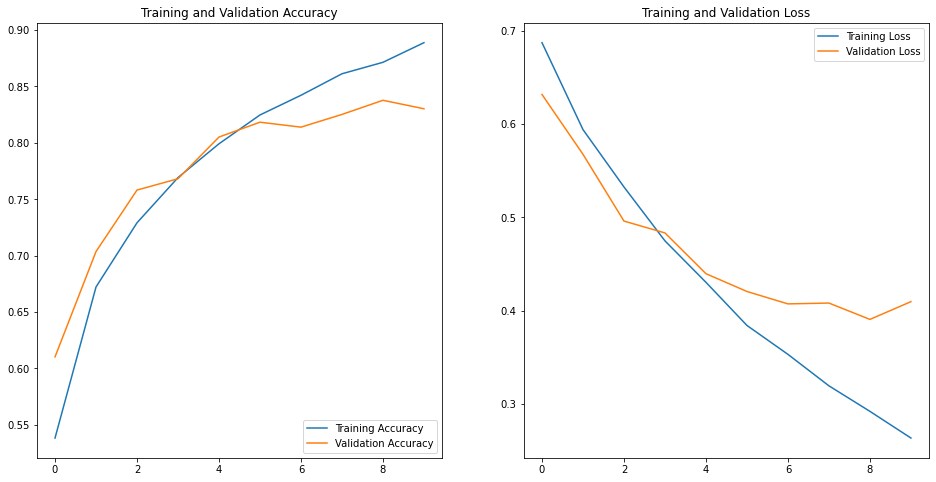

In [30]:
# plot accuracies and losses

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The validation accuracy still reaches a peak of 83%, but now this peak happens at epoch 9 and the distance between training accuracy and validation accuracy is a lot smaller. This indicates that the model does not overfit anymore.

## 5-Fold Cross Validation for Model 3

The third and final model is tested on the Test set using 5-fold cross validation.

In [31]:
# Parameter configuration

input_shape = (100, 100, 3)
no_epochs = 40
verbosity = 1
fold_no = 5
learning_rate=1e-3

In [32]:
# Define per-fold score containers

acc_per_fold = []
loss_per_fold = []


In [33]:
# Merge inputs and targets

inputs = images_test
targets = labels_test


In [34]:
# Define the K-fold Cross Validator

kfold = StratifiedKFold(n_splits=fold_no, shuffle = True)
kfold.get_n_splits(inputs, targets)

5

In [36]:
# K-fold Cross Validation model evaluation

for fold_no, (train_indexes, val_indexes) in enumerate(kfold.split(inputs, targets)):

    validation_data_X = np.array([inputs[idx].numpy() for idx in val_indexes])
    validation_data_y = np.array([targets[idx].numpy() for idx in val_indexes])
    training_data_X = np.array([inputs[idx].numpy() for idx in train_indexes])
    training_data_y = np.array([targets[idx].numpy() for idx in train_indexes])
    
    
    # Define the model architecture
    model_3 = Sequential([
      layers.Rescaling(1./255, input_shape=(100, 100, 3)),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(rate= 0.4),  
      layers.Conv2D(32, 6, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(rate= 0.4),  
      layers.Conv2D(64, 9, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(rate= 0.4),
      layers.Conv2D(128, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(rate= 0.4),    
      layers.Flatten(),
      layers.Dense(128, activation='sigmoid'),
      layers.Dense(2),
    ])
    
    
    # Compile the model
    model_3.compile(Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    
   # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

   # Fit data to model
    history = model_3.fit(
        x=training_data_X,
        y=training_data_y,
        epochs=no_epochs,
        verbose=1,
    )


   # Generate generalization metrics
    scores = model_3.evaluate(
        x=validation_data_X,
        y=validation_data_y,
        verbose=1,)
    print(f'Score for fold {fold_no}: {model_3.metrics_names[0]} of {scores[0]}; {model_3.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])


# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------') 
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 0 ...
Epoch 1/40
210/210 [==============================] - 131s 620ms/step - loss: 0.7001 - accuracy: 0.4993
Epoch 2/40
210/210 [==============================] - 125s 593ms/step - loss: 0.6966 - accuracy: 0.4944
Epoch 3/40
210/210 [==============================] - 124s 589ms/step - loss: 0.6955 - accuracy: 0.4945
Epoch 4/40
210/210 [==============================] - 123s 587ms/step - loss: 0.6953 - accuracy: 0.4959
Epoch 5/40
210/210 [==============================] - 123s 584ms/step - loss: 0.6983 - accuracy: 0.5025
Epoch 6/40
210/210 [==============================] - 123s 586ms/step - loss: 0.6973 - accuracy: 0.4881
Epoch 7/40
210/210 [==============================] - 124s 588ms/step - loss: 0.6945 - accuracy: 0.5074
Epoch 8/40
210/210 [==============================] - 123s 585ms/step - loss: 0.6962 - accuracy: 0.4950
Epoch 9/40
210/210 [==============================] - 124s 591ms/step -

210/210 [==============================] - 124s 591ms/step - loss: 0.6976 - accuracy: 0.5024
Epoch 29/40
210/210 [==============================] - 124s 592ms/step - loss: 0.6961 - accuracy: 0.5013
Epoch 30/40
210/210 [==============================] - 124s 592ms/step - loss: 0.6952 - accuracy: 0.4996
Epoch 31/40
210/210 [==============================] - 125s 594ms/step - loss: 0.6954 - accuracy: 0.4939
Epoch 32/40
210/210 [==============================] - 124s 593ms/step - loss: 0.6945 - accuracy: 0.5055
Epoch 33/40
210/210 [==============================] - 124s 591ms/step - loss: 0.6958 - accuracy: 0.5016
Epoch 34/40
210/210 [==============================] - 124s 593ms/step - loss: 0.6974 - accuracy: 0.4963
Epoch 35/40
210/210 [==============================] - 124s 593ms/step - loss: 0.6952 - accuracy: 0.4984
Epoch 36/40
210/210 [==============================] - 124s 591ms/step - loss: 0.6945 - accuracy: 0.5007
Epoch 37/40
210/210 [==============================] - 124s 593ms/s

In [38]:
zero_one_loss = 1 - sum(loss_per_fold) / len(loss_per_fold)
print(zero_one_loss)

0.3038950562477112


In the end, the average scores for all folds were an accuracy of 49% and a zero-one-loss of 30%.